In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from datetime import datetime

## Data

In [140]:
ticker = 'JPM.US'
interval = 'd'
url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
csv_file = ticker + '.csv'
urlretrieve(url, csv_file)
df = pd.read_csv(csv_file, index_col='Date', parse_dates=['Date'],
            date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-02,160.02,161.6100,159.430,160.46,8815634.0
2021-09-03,160.39,160.8900,159.145,159.49,7961223.0
2021-09-07,159.99,161.3814,158.960,159.21,9290968.0
2021-09-08,158.89,159.5800,158.040,158.50,7852678.0
2021-09-09,158.27,160.8325,158.080,159.19,7904256.0


In [141]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1970-01-02,2.8060,2.8060,2.7759,2.8060,32802.0
1970-01-05,2.8060,2.8133,2.7835,2.8060,42823.0
1970-01-06,2.8060,2.8357,2.7909,2.8357,37362.0
1970-01-07,2.8433,2.9179,2.8433,2.9030,98412.0
1970-01-08,2.8955,2.8955,2.8584,2.8955,29158.0


In [142]:
df = df.iloc[:, :-1]
df

,Open,High,Low,Close
Date,,,,
1970-01-02,2.8060,2.8060,2.7759,2.8060
1970-01-05,2.8060,2.8133,2.7835,2.8060
1970-01-06,2.8060,2.8357,2.7909,2.8357
1970-01-07,2.8433,2.9179,2.8433,2.9030
1970-01-08,2.8955,2.8955,2.8584,2.8955
...,...,...,...,...
2021-09-02,160.0200,161.6100,159.4300,160.4600
2021-09-03,160.3900,160.8900,159.1450,159.4900
2021-09-07,159.9900,161.3814,158.9600,159.2100


<AxesSubplot:xlabel='Date'>

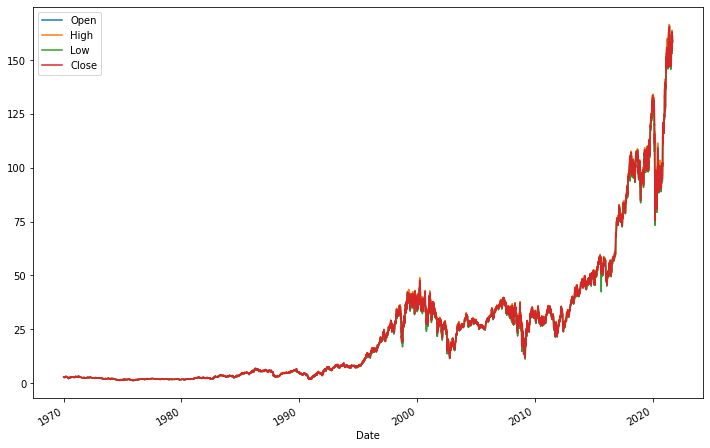

In [143]:
df.plot(figsize=(12,8))

## Creating logarithmic returns and volatility measure

In [144]:
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

# Compute Volatility using the pandas rolling standard deviation function
df['Volatility'] = df['Log_Ret'].rolling(window=252).std() * np.sqrt(252)
df.tail()

,Open,High,Low,Close,Log_Ret,Volatility
Date,,,,,,
2021-09-02,160.02,161.6100,159.430,160.46,0.004622,0.268903
2021-09-03,160.39,160.8900,159.145,159.49,-0.006063,0.268973
2021-09-07,159.99,161.3814,158.960,159.21,-0.001757,0.268284
2021-09-08,158.89,159.5800,158.040,158.50,-0.004469,0.265744
2021-09-09,158.27,160.8325,158.080,159.19,0.004344,0.265648


<AxesSubplot:xlabel='Date'>

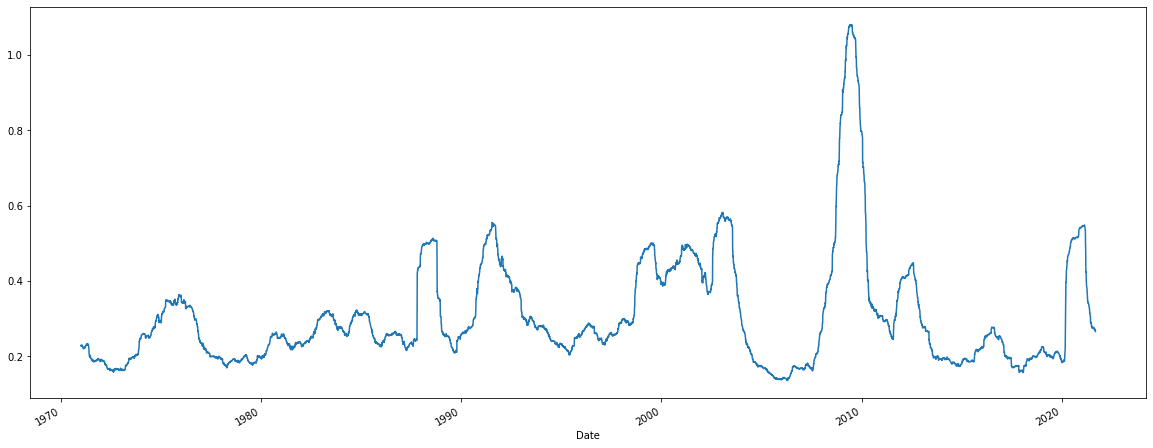

In [145]:
df['Volatility'].plot(figsize=(20,8))

<AxesSubplot:xlabel='Date'>

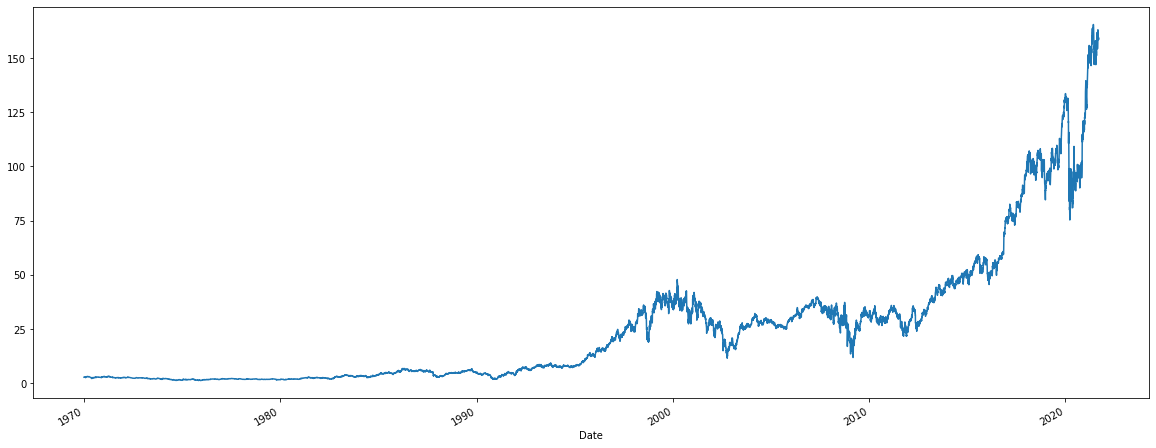

In [146]:
df['Close'].plot(figsize=(20,8))

## Train Test Split

In [147]:
df = df.drop(df.columns[[0, 1, 2, 3, 4]], axis=1)  # df.columns is zero-based pd.Index
df = df.iloc[252:]
df

,Volatility
Date,
1970-12-31,0.228474
1971-01-04,0.228706
1971-01-05,0.228486
1971-01-06,0.227500
1971-01-07,0.228727
...,...
2021-09-02,0.268903
2021-09-03,0.268973
2021-09-07,0.268284


In [148]:
len(df)

12784

In [149]:
size = 252 #int(len(df)*0.8)
train, test = df.iloc[:-size], df.iloc[-size:]

# 252 - average trading days

In [150]:
len(test)

252

In [151]:
train

,Volatility
Date,
1970-12-31,0.228474
1971-01-04,0.228706
1971-01-05,0.228486
1971-01-06,0.227500
1971-01-07,0.228727
...,...
2020-09-02,0.512842
2020-09-03,0.512353
2020-09-04,0.512805


## Scale Data

In [152]:
from sklearn.preprocessing import MinMaxScaler

In [153]:
scaler = MinMaxScaler()

In [154]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [155]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [156]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [157]:
# scaled_train

array([[0.09855293],
       [0.09879794],
       [0.09856575],
       ...,
       [0.39935333],
       [0.39999802],
       [0.39991939]])

In [159]:
# len(scaled_train)

12532

In [160]:
# len(generator)

12502

In [161]:
# scaled_train

array([[0.09855293],
       [0.09879794],
       [0.09856575],
       ...,
       [0.39935333],
       [0.39999802],
       [0.39991939]])

In [162]:
# # What does the first batch look like?
# X,y = generator[0]

In [163]:
# print(f'Given the Array: \n{X.flatten()}')
# print(f'Predict this y: \n {y}')

Given the Array: 
[0.09855293 0.09879794 0.09856575 0.09752188 0.09882023 0.09762766
 0.09694627 0.09739152 0.09756937 0.09791575 0.09688107 0.09919877
 0.0995147  0.09915119 0.09921496 0.09908623 0.09866795 0.09874062
 0.09868366 0.09439227 0.09374963 0.0936925  0.09317747 0.09317747
 0.09316582 0.0938572  0.09215518 0.09208897 0.09006818 0.09013359]
Predict this y: 
 [[0.09011864]]


In [164]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 252
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [165]:
# What does the first batch look like?
X,y = generator[0]

In [ ]:
len(generatorrator)

In [166]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.09855293 0.09879794 0.09856575 0.09752188 0.09882023 0.09762766
 0.09694627 0.09739152 0.09756937 0.09791575 0.09688107 0.09919877
 0.0995147  0.09915119 0.09921496 0.09908623 0.09866795 0.09874062
 0.09868366 0.09439227 0.09374963 0.0936925  0.09317747 0.09317747
 0.09316582 0.0938572  0.09215518 0.09208897 0.09006818 0.09013359
 0.09011864 0.09011876 0.08988505 0.08950764 0.08943809 0.090201
 0.09093207 0.09046914 0.09048387 0.09017508 0.0923828  0.09225784
 0.09255977 0.09278118 0.09280472 0.09113841 0.09185437 0.0925608
 0.09328516 0.09398819 0.09398576 0.09327576 0.09385876 0.09551493
 0.09503272 0.09706997 0.09725964 0.09725103 0.09733997 0.0978983
 0.09798242 0.09799252 0.09887068 0.09928772 0.09928772 0.09951477
 0.09983653 0.09988969 0.09923454 0.0990914  0.09930422 0.1023077
 0.10249989 0.10245197 0.10255345 0.10260386 0.1037721  0.10357185
 0.10363764 0.10285709 0.10142507 0.10084281 0.10052949 0.10126453
 0.10214862 0.10215995 0.10271875 0.10252004 0.10

### Create the Model

In [167]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [168]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [169]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [171]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                            length=30, batch_size=n_features)

In [172]:
model.fit(generator,epochs=50,
                     validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/50
12280/12280 [==============================] - 1152s 94ms/step - loss: 2.9487e-04 - val_loss: 2.5490e-05
Epoch 2/50
12280/12280 [==============================] - 1113s 91ms/step - loss: 5.5038e-05 - val_loss: 1.8851e-05
Epoch 3/50
12280/12280 [==============================] - 1121s 91ms/step - loss: 3.9545e-05 - val_loss: 1.9333e-05


In [173]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

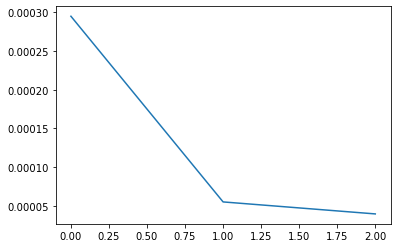

In [174]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

In [179]:
first_eval_batch = scaled_train[-size:]

In [180]:
first_eval_batch

array([[0.08031483],
       [0.08030451],
       [0.08089305],
       [0.08108269],
       [0.08114819],
       [0.08135862],
       [0.08135458],
       [0.07938009],
       [0.07920229],
       [0.07952767],
       [0.07935801],
       [0.07950732],
       [0.07921999],
       [0.07916207],
       [0.07948775],
       [0.08045846],
       [0.08041766],
       [0.08133051],
       [0.08115298],
       [0.08234471],
       [0.08238042],
       [0.08274282],
       [0.08154612],
       [0.07920204],
       [0.0810123 ],
       [0.08092987],
       [0.07989563],
       [0.07961928],
       [0.08037712],
       [0.0805738 ],
       [0.08000281],
       [0.0796921 ],
       [0.07884683],
       [0.07836177],
       [0.07781641],
       [0.0775022 ],
       [0.07693195],
       [0.07706563],
       [0.07719792],
       [0.07710081],
       [0.07701602],
       [0.07703679],
       [0.07638008],
       [0.07628505],
       [0.07611374],
       [0.07496435],
       [0.07489973],
       [0.073

In [181]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [182]:
model.predict(first_eval_batch)

array([[0.3986502]], dtype=float32)

In [183]:
scaled_test[0]

array([0.40000867])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [184]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [185]:
current_batch.shape

(1, 252, 1)

In [186]:
current_batch

array([[[0.08031483],
        [0.08030451],
        [0.08089305],
        [0.08108269],
        [0.08114819],
        [0.08135862],
        [0.08135458],
        [0.07938009],
        [0.07920229],
        [0.07952767],
        [0.07935801],
        [0.07950732],
        [0.07921999],
        [0.07916207],
        [0.07948775],
        [0.08045846],
        [0.08041766],
        [0.08133051],
        [0.08115298],
        [0.08234471],
        [0.08238042],
        [0.08274282],
        [0.08154612],
        [0.07920204],
        [0.0810123 ],
        [0.08092987],
        [0.07989563],
        [0.07961928],
        [0.08037712],
        [0.0805738 ],
        [0.08000281],
        [0.0796921 ],
        [0.07884683],
        [0.07836177],
        [0.07781641],
        [0.0775022 ],
        [0.07693195],
        [0.07706563],
        [0.07719792],
        [0.07710081],
        [0.07701602],
        [0.07703679],
        [0.07638008],
        [0.07628505],
        [0.07611374],
        [0

In [187]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[8.03045080e-02],
        [8.08930491e-02],
        [8.10826871e-02],
        [8.11481860e-02],
        [8.13586211e-02],
        [8.13545755e-02],
        [7.93800948e-02],
        [7.92022857e-02],
        [7.95276709e-02],
        [7.93580063e-02],
        [7.95073166e-02],
        [7.92199850e-02],
        [7.91620651e-02],
        [7.94877525e-02],
        [8.04584596e-02],
        [8.04176599e-02],
        [8.13305068e-02],
        [8.11529754e-02],
        [8.23447052e-02],
        [8.23804152e-02],
        [8.27428204e-02],
        [8.15461155e-02],
        [7.92020389e-02],
        [8.10122998e-02],
        [8.09298682e-02],
        [7.98956329e-02],
        [7.96192816e-02],
        [8.03771156e-02],
        [8.05738002e-02],
        [8.00028063e-02],
        [7.96920959e-02],
        [7.88468272e-02],
        [7.83617715e-02],
        [7.78164064e-02],
        [7.75022009e-02],
        [7.69319496e-02],
        [7.70656317e-02],
        [7.71979162e-02],
        [7.7

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [188]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [189]:
test_predictions

[array([0.3986502], dtype=float32),
 array([0.3975961], dtype=float32),
 array([0.39646617], dtype=float32),
 array([0.39528018], dtype=float32),
 array([0.39405492], dtype=float32),
 array([0.39280054], dtype=float32),
 array([0.39152312], dtype=float32),
 array([0.39022636], dtype=float32),
 array([0.38891238], dtype=float32),
 array([0.38758263], dtype=float32),
 array([0.38623795], dtype=float32),
 array([0.38487893], dtype=float32),
 array([0.38350603], dtype=float32),
 array([0.38211954], dtype=float32),
 array([0.3807197], dtype=float32),
 array([0.37930673], dtype=float32),
 array([0.3778808], dtype=float32),
 array([0.37644204], dtype=float32),
 array([0.3749905], dtype=float32),
 array([0.37352636], dtype=float32),
 array([0.37204957], dtype=float32),
 array([0.37056026], dtype=float32),
 array([0.36905837], dtype=float32),
 array([0.367544], dtype=float32),
 array([0.3660171], dtype=float32),
 array([0.36447778], dtype=float32),
 array([0.36292595], dtype=float32),
 array([0

In [190]:
scaled_test

array([[0.40000867],
       [0.40013794],
       [0.39992836],
       [0.40085481],
       [0.40085968],
       [0.40086836],
       [0.40086384],
       [0.40182618],
       [0.40193344],
       [0.40202814],
       [0.40198804],
       [0.40202647],
       [0.40285457],
       [0.40291661],
       [0.40270218],
       [0.4023664 ],
       [0.40246662],
       [0.40244904],
       [0.40254705],
       [0.40236571],
       [0.40274503],
       [0.40256496],
       [0.40242327],
       [0.40267451],
       [0.40176421],
       [0.40200468],
       [0.40197018],
       [0.40224187],
       [0.40162759],
       [0.40160072],
       [0.40287797],
       [0.40297449],
       [0.40351188],
       [0.40383282],
       [0.40461554],
       [0.40464893],
       [0.40471434],
       [0.40468731],
       [0.40564982],
       [0.40658179],
       [0.40827814],
       [0.40840127],
       [0.42471109],
       [0.42470901],
       [0.42489477],
       [0.42501225],
       [0.42505263],
       [0.425

## Inverse Transformations and Compare

In [191]:
true_predictions = scaler.inverse_transform(test_predictions)

In [192]:
true_predictions

array([[0.51214051],
       [0.51114411],
       [0.51007605],
       [0.50895501],
       [0.50779683],
       [0.50661113],
       [0.50540365],
       [0.50417789],
       [0.50293585],
       [0.50167891],
       [0.50040785],
       [0.49912325],
       [0.49782551],
       [0.49651493],
       [0.49519173],
       [0.49385613],
       [0.49250828],
       [0.49114829],
       [0.48977622],
       [0.48839225],
       [0.48699631],
       [0.48558855],
       [0.48416889],
       [0.48273743],
       [0.48129414],
       [0.4798391 ],
       [0.47837223],
       [0.47689361],
       [0.47540327],
       [0.47390116],
       [0.47238727],
       [0.47086164],
       [0.46932426],
       [0.46777516],
       [0.46621431],
       [0.46464171],
       [0.4630574 ],
       [0.46146137],
       [0.45985362],
       [0.45823423],
       [0.45660318],
       [0.4549605 ],
       [0.45330621],
       [0.45164034],
       [0.4499629 ],
       [0.44827393],
       [0.44657347],
       [0.444

In [193]:
test

,Volatility
Date,
2020-09-10,0.513425
2020-09-11,0.513547
2020-09-14,0.513349
2020-09-15,0.514224
2020-09-16,0.514229
...,...
2021-09-02,0.268903
2021-09-03,0.268973
2021-09-07,0.268284


In [194]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

<ipython-input-194-53e06c23926f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [195]:
test

,Volatility,Predictions
Date,,
2020-09-10,0.513425,0.512141
2020-09-11,0.513547,0.511144
2020-09-14,0.513349,0.510076
2020-09-15,0.514224,0.508955
2020-09-16,0.514229,0.507797
...,...,...
2021-09-02,0.268903,0.163115
2021-09-03,0.268973,0.162973
2021-09-07,0.268284,0.162836


<AxesSubplot:xlabel='Date'>

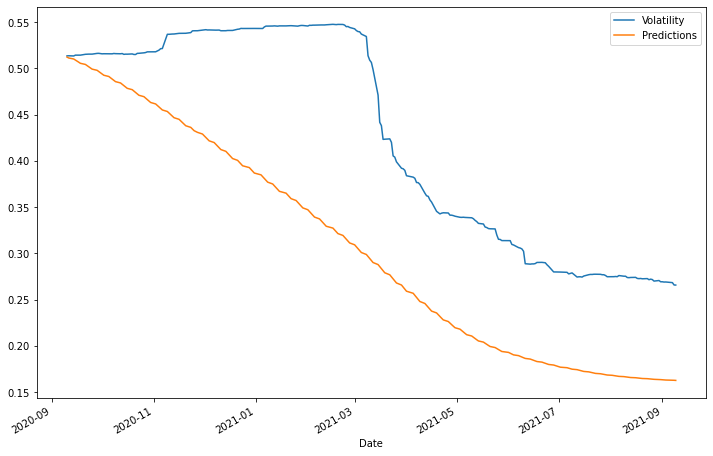

In [196]:
test.plot(figsize=(12,8))

In [200]:
    print(np.mean(np.square(test['Predictions'] - test['Volatility'])))
    print(np.mean(np.abs(test['Predictions'] - test['Volatility'])))
    print(np.mean(np.abs((test['Volatility'] - test['Predictions']) / test['Volatility'])))

0.017121585281663024
0.11884382883266799
0.29710077429259024


# Saving and Loading Models

In [197]:
model.save('my_rnn_model.h5')

## load a model

In [198]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [199]:
new_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
